In [1]:
from Bio import Phylo
import numpy as np
import math
import random
from numpy.random import default_rng
rng = default_rng() # random number generator

In [2]:
# set up parameters 
u0 = 1e-6 # mutation rate of chromosome
u1 = 1e-4 # mutation rate of gene locus
a = 0.02 # gene gain rate 
b = 0.02 # gene loss rate 
n = 10 # number of initial copies, must be greater than 5 to push the program to run
l = 20 # length of the gene sequence (AA)

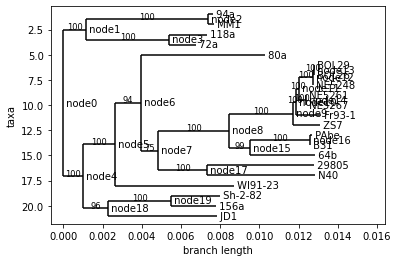

node0


In [53]:
tree = Phylo.read("Bb_genome_reduced.tree", "newick") # genome tree of B.burgdorferi
internal_clades = tree.get_nonterminals()
for i in range(len(internal_clades)):
    internal_clades[i].name = "node%i" %i # name internal nodes
Phylo.draw(tree)
print(tree.root)

In [54]:
# to do: use Bio.Seq, so gene lineages could be tracked through ids
# eg. g0 through g9
def random_protein_sequence(l, n):
    AA = ('A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V')
    copies = []
    seq = ''.join(np.random.choice(AA) for _ in range(l))
    copies.extend([seq]*n)
    return copies

In [55]:
def mutation(genes, prob):
    for i in range(len(genes)):
        n_mut =  rng.poisson(prob) # determine how many sites to be mutated
        if n_mut > 0:
            seq = list(genes[i])
            sites_mut = random.sample(range(l), n_mut) # choose the sites to mutate
            for site in sites_mut: # mutate the sites one by one
                AA = ['A','R','N','D','C','E','Q','G','H','I','L','K','M','F','P','S','T','W','Y','V']
                ori = seq[site]
                AA.remove(ori) # remove the original letter to avoid sampling the same one
                seq[site] = np.random.choice(AA) # random substitution
            genes[i] = ''.join(seq)
    return(genes) 

In [56]:
# to do: track duplication copies
# e.g., g0_1, g9_2, etc
def duplication(genes, prob):
    n_gain = rng.poisson(prob) # determine how many copies to be duplicated
    if n_gain > 0:
        gene_gain = random.sample(genes, n_gain) # choose the copies to duplicate 
        genes = genes + gene_gain # add items to the gene set
    return(genes)

In [57]:
def deletion(genes, prob):
    n_loss = rng.poisson(prob) # determine how many copies to be deleted
    if n_loss > 0:
        gene_loss = random.sample(genes, n_loss) # choose the copies to delete
        for item in gene_loss: # remove items from the set one by one
            genes.remove(item)
    return(genes)

In [58]:
def write_fasta(dictionary, filename):
    import textwrap
    with open(filename, "w") as outfile:
        for key, value in dictionary.items():
            outfile.write(">" + key + "\n")
            outfile.write("\n".join(textwrap.wrap(value, 60)))
            outfile.write("\n")

In [59]:
# from: https://biopython.org/wiki/Phylo_cookbook
# more efficient than calling get_path repeatedly
def all_parents(tree):
    parents = {}
    for clade in tree.find_clades(order="level"):
        for child in clade:
            parents[child.name] = clade
    return parents


# Example
parents = all_parents(tree)
print(parents)
#myclade = tree.find_clades("1_node1").next()
#parent_of_myclade = parents[myclade]
#assert myclade in parent_of_myclade


{'node1': Clade(name='node0'), 'node4': Clade(name='node0'), 'node2': Clade(branch_length=0.0011477927, confidence=100, name='node1'), 'node3': Clade(branch_length=0.0011477927, confidence=100, name='node1'), 'node5': Clade(branch_length=0.0010085381, confidence=100, name='node4'), 'node18': Clade(branch_length=0.0010085381, confidence=100, name='node4'), '94a': Clade(branch_length=0.0062413991, confidence=100, name='node2'), 'MM1': Clade(branch_length=0.0062413991, confidence=100, name='node2'), '118a': Clade(branch_length=0.0042478301, confidence=100, name='node3'), '72a': Clade(branch_length=0.0042478301, confidence=100, name='node3'), 'node6': Clade(branch_length=0.00162392, confidence=100, name='node5'), 'WI91-23': Clade(branch_length=0.00162392, confidence=100, name='node5'), 'node19': Clade(branch_length=0.0012888114, confidence=96, name='node18'), 'JD1': Clade(branch_length=0.0012888114, confidence=96, name='node18'), '80a': Clade(branch_length=0.0013387139, confidence=94, name

In [63]:
### Main simulator by recursive tree walking ###
root_genes = random_protein_sequence(l, n)
genes_dic = {}

# recursive function to walk a tree
def walk_tree(clade):
    print(clade.name)
    if clade == tree.root:
        genes_dic[clade.name] = root_genes
    else:
        time = clade.branch_length/u0 # convert branch length to time
        p_mut = 1 - math.exp(-(u1*time)) # probability of mutation
        p_gain = (a/(a+b))*(1-math.exp(-((a+b)*time))) # probability of gain
        p_loss = 1 - p_gain # probability of loss
        
        parent = parents[clade.name].name
        genes = genes_dic[parent] # parent's gene set
        genes = mutation(genes, p_mut) 
        genes = duplication(genes, p_gain) 
        genes = deletion(genes, p_loss)
        genes_dic[clade.name] = genes # add new genes to the dic
    
    if clade.is_terminal(): # stop at a terminal
        return
    else: # recurse for an internal node
        for child in clade:
            walk_tree(child)

# simulate by recursive walk from the root
walk_tree(tree.root)

node0
node1
node2
94a
MM1
node3
118a
72a
node4
node5
node6
80a
node7
node8
node9
node10
node11
node12
node13
BOL29
BOL26
NE5248
node14
NE5261
NE5267
Fr93-1
ZS7
node15
node16
PAbe
B31
64b
node17
29805
N40
WI91-23
node18
node19
Sh-2-82
156a
JD1


In [ ]:
### Main simulator ###
# initiation 
root = random_protein_sequence(l, n)
genes_dic = {}
genes_dic['node0'] = root

# tree_walking and evolution
allclades = list(tree.find_clades(order="level"))
for clade in allclades[1:]: 
    time = clade.branch_length/u0 # convert branch length to time
    p_mut = 1 - math.exp(-(u1*time)) # probability of mutation
    p_gain = (a/(a+b))*(1-math.exp(-((a+b)*time))) # probability of gain
    p_loss = 1 - p_gain # probability of loss
    
    path = tree.get_path(clade.name)
    if len(path) <= 1:
        parent = 'node0'
    else:
        parent = path[-2].name # get the name of the parent node
        
    genes = genes_dic[parent] # parent's gene set
    genes = mutation(genes, p_mut) 
    genes = duplication(genes, p_gain) 
    genes = deletion(genes, p_loss)
    genes_dic[clade.name] = genes # add new genes to the dic
            
print("Simulation is done!")    

In [61]:
# extract terminal names and genes
tips = [tip.name for tip in tree.get_terminals()]
seq_dic = {}
for taxon in tips:
    for i in range(len(genes_dic[taxon])):
        seq_dic["%s_%i" %(taxon, (i+1))] = genes_dic[taxon][i]
    
# export simulated sequences to a fasta file
write_fasta(seq_dic, "bb_vls_sim2.fas")
print("Success! File written") 

Success! File written
